In [129]:
import pandas as pd
import seaborn as sns
import duckdb


In [130]:
def eurostat_reshape(data,metric_name,id_vars):

    # Melt işlemi: Tüm tarih sütunlarını tek sütunda topluyoruz
    data_melted = data.melt(id_vars=id_vars, 
                        var_name="TIME_PERIOD", 
                        value_name=metric_name)
    
    data_melted = data_melted[['TIME_PERIOD',"Country Code",metric_name]]

    # Rename columns for simplicity
    data_melted.columns = ['DATE',"GEO", metric_name]
    data_melted.dropna(inplace=True)
    # Convert "DATE" to Year-Month format
    #df["DATE"] = pd.to_datetime(df["DATE"]).dt.to_period("M")
    return data_melted


In [131]:
population = pd.read_csv('/Users/emirysaglam/GitHub/Bitirme2/API_SP.POP.TOTL_DS2_en_csv_v2_26346.csv')
fra_pop = population[population["Country Code"]== "FRA"]
fra_pop

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
77,France,FRA,"Population, total",SP.POP.TOTL,47412964.0,47905982.0,48389516.0,48877567.0,49401492.0,49877725.0,...,66548272.0,66724104.0,66918020.0,67158348.0,67382061.0,67601110.0,67842811.0,68065015.0,68287487.0,NaN


In [132]:
fra_pop_re = eurostat_reshape(fra_pop,'POP',['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
fra_pop_re

,DATE,GEO,POP
0,1960,FRA,47412964.0
1,1961,FRA,47905982.0
2,1962,FRA,48389516.0
3,1963,FRA,48877567.0
4,1964,FRA,49401492.0
...,...,...,...
59,2019,FRA,67382061.0
60,2020,FRA,67601110.0
61,2021,FRA,67842811.0
62,2022,FRA,68065015.0


In [133]:
fra_pop_re['DATE'] = pd.to_datetime(fra_pop_re['DATE'].astype(str) + '-01').dt.date

fra_pop_re

,DATE,GEO,POP
0,1960-01-01,FRA,47412964.0
1,1961-01-01,FRA,47905982.0
2,1962-01-01,FRA,48389516.0
3,1963-01-01,FRA,48877567.0
4,1964-01-01,FRA,49401492.0
...,...,...,...
59,2019-01-01,FRA,67382061.0
60,2020-01-01,FRA,67601110.0
61,2021-01-01,FRA,67842811.0
62,2022-01-01,FRA,68065015.0


In [134]:
fra_pop_re.dtypes

DATE     object
GEO      object
POP     float64
dtype: object

<Axes: xlabel='DATE', ylabel='POP'>

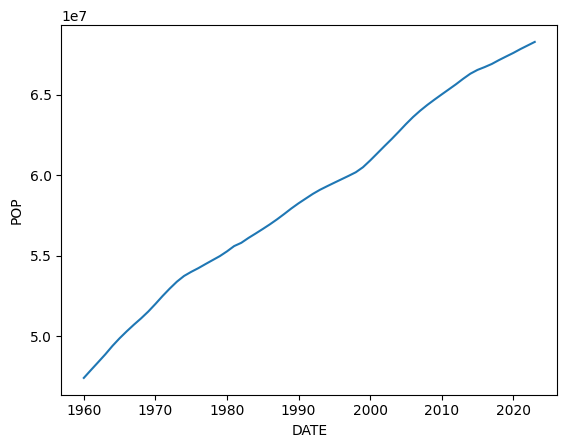

In [135]:
sns.lineplot(fra_pop_re,x="DATE",y="POP")

In [136]:
pd.to_datetime(fra_pop_re['DATE'], format='%Y-%m')


0    1960-01-01
1    1961-01-01
2    1962-01-01
3    1963-01-01
4    1964-01-01
        ...    
59   2019-01-01
60   2020-01-01
61   2021-01-01
62   2022-01-01
63   2023-01-01
Name: DATE, Length: 64, dtype: datetime64[ns]

In [137]:
# Create the DataFrame
df = fra_pop_re.copy()

# Create a monthly date range from the first to the last available date
date_range = pd.date_range(start=df['DATE'].min(), end=df['DATE'].max(), freq='M')

# Create a new DataFrame with all the months in the range
df_full = pd.DataFrame(date_range, columns=['DATE'])
df_full["DATE"] = df_full["DATE"].dt.to_period("M")
df_full["POP"] = None
df_full


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_6228/2829300137.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=df['DATE'].min(), end=df['DATE'].max(), freq='M')


,DATE,POP
0,1960-01,None
1,1960-02,None
2,1960-03,None
3,1960-04,None
4,1960-05,None
...,...,...
751,2022-08,None
752,2022-09,None
753,2022-10,None
754,2022-11,None


In [138]:
df["DATE"] = pd.to_datetime(df["DATE"]).dt.to_period("M")
df

,DATE,GEO,POP
0,1960-01,FRA,47412964.0
1,1961-01,FRA,47905982.0
2,1962-01,FRA,48389516.0
3,1963-01,FRA,48877567.0
4,1964-01,FRA,49401492.0
...,...,...,...
59,2019-01,FRA,67382061.0
60,2020-01,FRA,67601110.0
61,2021-01,FRA,67842811.0
62,2022-01,FRA,68065015.0


In [139]:
# Merge with the original data, allowing for missing months
df_merged = pd.merge(df_full, df, on='DATE', how='left')

# Display the result with null values for the months that were missing
df_merged = df_merged[["DATE","POP_y"]]
df_merged

,DATE,POP_y
0,1960-01,47412964.0
1,1960-02,NaN
2,1960-03,NaN
3,1960-04,NaN
4,1960-05,NaN
...,...,...
751,2022-08,NaN
752,2022-09,NaN
753,2022-10,NaN
754,2022-11,NaN


In [141]:
import pandas as pd

# Set the 'DATE' column as the index
#df_merged.set_index('DATE', inplace=True)
df_merged['DATE'] = pd.to_datetime(df_merged['DATE'].astype(str) + '-01').dt.date


# Perform linear interpolation on missing values
df_merged['POP_y'] = df_merged['POP_y'].interpolate(method='linear')

# Display the result

df_merged

,DATE,POP_y
0,1960-01-01,4.741296e+07
1,1960-02-01,4.745405e+07
2,1960-03-01,4.749513e+07
3,1960-04-01,4.753622e+07
4,1960-05-01,4.757730e+07
...,...,...
751,2022-08-01,6.806502e+07
752,2022-09-01,6.806502e+07
753,2022-10-01,6.806502e+07
754,2022-11-01,6.806502e+07


In [142]:
df_merged.dtypes

DATE      object
POP_y    float64
dtype: object

<Axes: xlabel='DATE', ylabel='POP_y'>

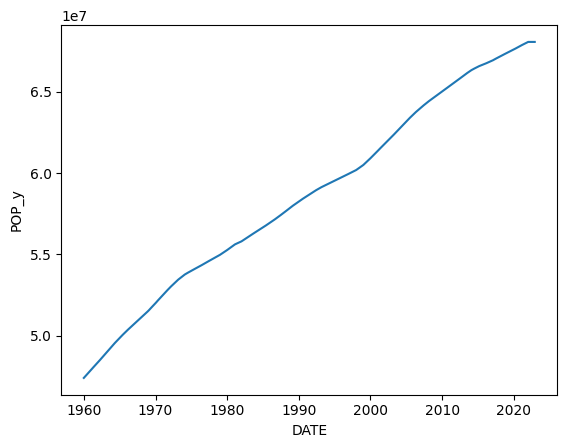

In [143]:
sns.lineplot(df_merged,x="DATE",y="POP_y")

In [149]:
    
df_merged["DATE"] = df_merged["DATE"].astype(str)


In [150]:
df_merged

,DATE,POP_y
0,1960-01,4.741296e+07
1,1960-02,4.745405e+07
2,1960-03,4.749513e+07
3,1960-04,4.753622e+07
4,1960-05,4.757730e+07
...,...,...
751,2022-08,6.806502e+07
752,2022-09,6.806502e+07
753,2022-10,6.806502e+07
754,2022-11,6.806502e+07


In [146]:
con = duckdb.connect("data.db")


In [152]:
#con.execute("CREATE TABLE world_bank AS SELECT * FROM df_merged")
con.sql("SELECT * FROM world_bank").df()         # Pandas DataFrame


,DATE,POP_y
0,1960-01,4.741296e+07
1,1960-02,4.745405e+07
2,1960-03,4.749513e+07
3,1960-04,4.753622e+07
4,1960-05,4.757730e+07
...,...,...
751,2022-08,6.806502e+07
752,2022-09,6.806502e+07
753,2022-10,6.806502e+07
754,2022-11,6.806502e+07


In [153]:
con.close()